# 🚩 Basic usage

**Welcome to `redflag`.** It's still early days for this library, but there are a few things you can do:

- Outlier detection
- Clipping detection
- Imbalance metrics (for labels and any other categorical variables)
- Distribution shape
- Identical distribution assumption
- Independence assumption
- Feature importance metrics

In [1]:
import redflag as rf

rf.__version__

'0.1.8.dev40+gc30452b.d20220831'

## Load some data

In [2]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_training_data.csv')

# Look at the transposed summary: each column in the DataFrame is a row here.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Depth,3966.0,882.674555,40.150056,784.402800,858.012000,888.339600,913.028400,963.320400
RelPos,3966.0,0.524999,0.286375,0.010000,0.282000,0.531000,0.773000,1.000000
Marine,3966.0,1.325013,0.589539,0.000000,1.000000,1.000000,2.000000,2.000000
GR,3966.0,64.367899,28.414603,12.036000,45.311250,64.840000,78.809750,200.000000
ILD,3966.0,5.240308,3.190416,0.340408,3.169567,4.305266,6.664234,32.136605
DeltaPHI,3966.0,3.469088,4.922310,-21.832000,1.000000,3.292500,6.124750,18.600000
PHIND,3966.0,13.008807,6.936391,0.550000,8.196250,11.781500,16.050000,52.369000
PE,3966.0,3.686427,0.815113,0.200000,3.123000,3.514500,4.241750,8.094000
Facies,3966.0,4.471004,2.406180,1.000000,2.000000,4.000000,6.000000,9.000000
LATITUDE,3966.0,37.632575,0.299398,37.180732,37.356426,37.500380,37.910583,38.063373


## Descriptive

We can use `is_continuous()` to check if a feature (or the target) is continuous (as opposed to categorical).

In [3]:
for col in df.columns:
    print(f"{col:>20s} ... {rf.is_continuous(df[col])}")

           Well Name ... False
               Depth ... True
           Formation ... False
              RelPos ... True
              Marine ... False
                  GR ... True
                 ILD ... True
            DeltaPHI ... True
               PHIND ... True
                  PE ... True
              Facies ... False
            LATITUDE ... True
           LONGITUDE ... True
           ILD_log10 ... True
           Lithology ... False
                RHOB ... True
          Mineralogy ... False
       Siliciclastic ... False


This has missed the **Facies** column, which is categorical. But the others are correct.

## Imbalance metrics

First, we'll look at measuring imbalance in the target using `rf.class_imbalance()`. For binary targets, the metric is imbalace ratio (ratio between majority and minority class). For multiclass targets, the metric is imbalance degree [(Ortigosa-Hernandez et al, 2017)](https://doi.org/10.1016/j.patrec.2017.08.002), a single-value measure that explains (a) how many minority classes there are and (b) how skewed the supports are.

In [4]:
rf.imbalance_ratio(df['Lithology'])

8.347368420878391

To interpret this number, split it into two parts:

- The integer part, 3, is equal to $m - 1$, where $m$ is the number of minority classes.
- The fractional part, 0.378..., is a measure of the amount of imbalance, where 0 means the dataset is balanced perfectly and 0.999... is really bad.

If the imbalance degree is -1 then there are no minority classes and all the classes have equal support.

In general, this statistic is more informative than the commonly used 'imbalance ratio' (`rf.imbalance_ratio()`), which is the ratio of support in the maximum majority class to that in the minimum minority class, with no regard for the support of the other classes.

We can get the minority classes, which are those with fewer samples than expected. These are returned in order, smallest first:

In [5]:
rf.minority_classes(df['Lithology'])

array(['dolomite', 'sandstone', 'mudstone', 'wackestone'], dtype='<U10')

We can get the 'empirical distribution', which returns the observed frequencies `ζ` and the expectations `e`. 

In [6]:
ζ, e = rf.empirical_distribution(df['Lithology'])
ζ

array([0.39989914, 0.18582955, 0.15834594, 0.04790721, 0.13691377,
       0.07110439])

These are in the same order as `df['Lithology'].unique()` (note that this is different from the order of `np.unique()`, which is sorted).

In [7]:
df['Lithology'].unique()

array(['siltstone', 'limestone', 'wackestone', 'dolomite', 'mudstone',
       'sandstone'], dtype=object)

We can also inspect the distribution using Pandas; note that this display is sorted by count:

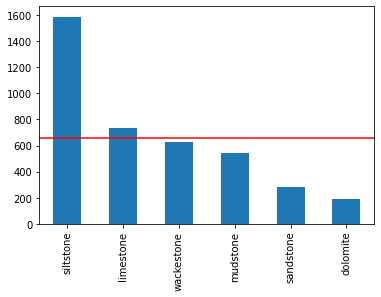

In [8]:
ax = df['Lithology'].value_counts().plot(kind='bar')

# Add a line at the expectation level, which is the same for all classes.
ax.axhline(e[0] * len(df), c='r')

## Outliers

The `get_outliers()` function detects outliers, returning the indices of outlier points.

In [9]:
outliers = rf.get_outliers(df['GR'])
outliers

array([ 301,  302,  303,  415,  416,  417,  418,  799,  896,  897,  898,
        899,  996,  997, 1843, 1844, 2278, 2279, 2280, 2638, 2639, 2640,
       2641, 2642, 2643, 2920, 2921, 2922, 3070, 3071, 3074, 3075, 3076,
       3079, 3080, 3081, 3580, 3581, 3582, 3583])

We can see where these lie in the distribution:

<AxesSubplot:xlabel='GR', ylabel='Density'>

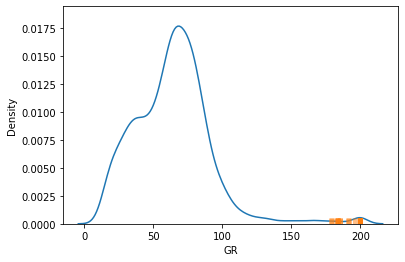

In [10]:
import seaborn as sns

sns.kdeplot(df['GR'])
sns.rugplot(df.loc[outliers, 'GR'], c='C1', lw=5, alpha=0.5)

By default it uses an [**isolation forest**](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest) to detect the outliers at the 99% confidence level, but you can also opt to use **local outlier factor**, **elliptic envelope**, or **Mahalanobis distance**, setting the confidence level to choose how many outliers you will see, or (equivalently) setting the `threshold` to the number of standard deviations away from the mean you regard as signal.

The function accepts univariate or multivariate data:

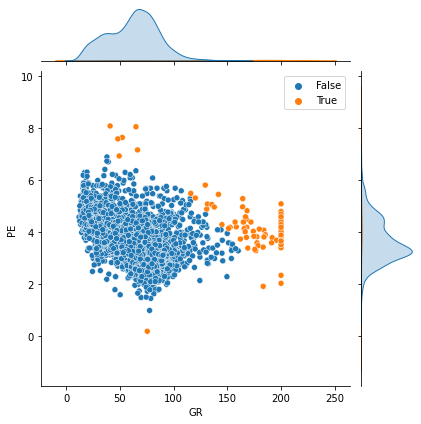

In [11]:
features = ['GR', 'PE']

outliers = rf.get_outliers(df[features], method='mah', threshold=5)

sns.jointplot(data=df, x='GR', y='PE', hue=rf.index_to_bool(outliers, n=len(df)))

A helper function can compute the number of expected outliers, given the dataset size and assuming a Gaussian distribution of samples.

In [12]:
print(f"We have {len(outliers)} outliers, but expect:")
rf.expected_outliers(*df[features].shape, threshold=3)

We have 80 outliers, but expect:


44

So we have more than expected &mdash; because the distribution of GR has a lot of clipped samples at a value of 200. A dataset with truncated tails will have fewer than expected outliers; we can test this directly with the `has_outliers()` function, which compares the results of `expected_outliers()` with `get_outliers()`:

In [13]:
import numpy as np

data = np.random.normal(size=10_000)

rf.expected_outliers(len(data), d=1, p=0.99)

100

In [14]:
# Truncate
data = data[(-2.5 < data) & (data <  2.5)]

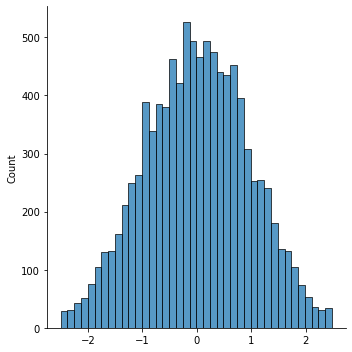

In [15]:
sns.displot(data)

This truncated normal distribution has no outliers (there are only about 60, compared to the 100 we expect at this confidence level of 99% on this dataset of 10,000 records).

In [16]:
rf.has_outliers(data, p=0.99)

False

## Clipping

If a feature has been clipped, it will have multiple instances at its min and/or max value. There are legitimate reasons why this might happen, for example the feature may be naturally bounded (e.g. porosity is always greater than 0), or the feature may have been deliberately clipped as part of the data preparation process.

In [17]:
rf.is_clipped(df['GR'])

True

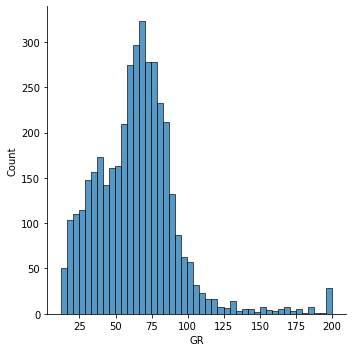

In [18]:
import seaborn as sns

sns.displot(df['GR'])

## Distribution shape

Tries to guess the shape of the distribution from the following set from `scipy.stats`:

- `'norm'`
- `'cosine'`
- `'expon'`
- `'exponpow'`
- `'gamma'`
- `'gumbel_l'`
- `'gumbel_r'`
- `'powerlaw'`
- `'triang'`
- `'trapz'`
- `'uniform'`

The name is returned, along with the shape parameters (if any), location and scale.

In spite of the outliers, we find that the distribution of GR values is nearly normal:

In [19]:
rf.best_distribution(df['GR'])

Distribution(name='norm', shape=[], loc=64.36789939485628, scale=28.411020184908292)

In contrast, the PHIND data is skewed andbest modeled by the [Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution).

In [20]:
rf.best_distribution(df['PHIND'])

Distribution(name='gumbel_r', shape=[], loc=10.040572536302586, scale=4.934329727517257)

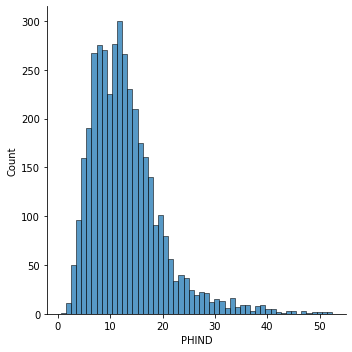

In [21]:
sns.displot(df['PHIND'])

## Identical distribution assumption

We'd often like to test the implicit assumption that our data are 'identically distributed' across various groups, with respect to both the labels and the features.

`redflag.wasserstein()` facilitates calculating the first Wasserstein distance (aka earth-mover's distance) between groups, e.g. between train and test datasets. It returns a score for each feature; scores greater than 1 can be interpreted as substantial differences in the distribution.

In [22]:
wells = df['Well Name']
features = ['GR', 'RHOB', 'ILD_log10', 'PE']

w = rf.wasserstein(df[features], groups=wells, standardize=True)
w

array([[0.25985545, 0.28404634, 0.49139232, 0.33701782],
       [0.22736457, 0.13473663, 0.33672956, 0.20969657],
       [0.41216725, 0.34568777, 0.39729747, 0.48092099],
       [0.0801856 , 0.10675027, 0.13740318, 0.10325295],
       [0.19913347, 0.21828753, 0.26995735, 0.33063277],
       [0.24612402, 0.23889923, 0.26699721, 0.2350674 ],
       [0.20666445, 0.44112543, 0.16229232, 0.63527036],
       [0.18187639, 0.34992043, 0.19400917, 0.74988182],
       [0.31761526, 0.27206283, 0.30255291, 0.24779581]])

You could plot this as a heatmap:

<AxesSubplot:>

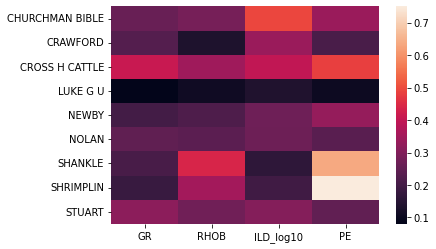

In [23]:
sns.heatmap(w, yticklabels=np.unique(wells), xticklabels=features)

This shows us that the distributions of the PE log in well indices 6 and 7 are somewhat different and may be anomalous. It also suggests that the CROSS H CATTLE well is different from the others.

### Already split out group arrays

If you have groups that are already split out, e.g. train and test datasets:

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_ = train_test_split(df[features], test_size=0.4, random_state=42)

# NOTE: We're doing a random split here for illustration purposes only.
# This is not a valid way to split the dataset, because rows are not indepedent.
X_val, X_test = train_test_split(X_, test_size=0.5, random_state=42)

# The data should be standardized to compare Wasserstein distance between features.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In this case, you can pass them into the function as a list or tuple:

In [25]:
rf.wasserstein([X_train, X_val, X_test])

array([[0.03860982, 0.02506236, 0.04321734, 0.03437337],
       [0.04402681, 0.02528225, 0.0385111 , 0.05694201],
       [0.04388196, 0.049464  , 0.05560379, 0.04002712]])

The numbers are all quite low because we sampled randomly from the data.

## Independence assumption

If a feature is correlated to lagged (shifted) versions of itself, then the dataset may be ordered by that feature, or the records may not be independent. If several features are correlated to themselves, then the data instances may not be independent.

In [26]:
rf.is_correlated(df['GR'])

True

This is order-dependent. That is, shuffling the data removes the correlation, but does not mean the records are independent.

In [27]:
gr = df['GR'].to_numpy(copy=True)
np.random.shuffle(gr)
rf.is_correlated(gr)

False

## Feature importance

We'd like to know which features are the most important.

`redflag` trains a series of models on your data, assessing which features are most important. It then normalizes and averages the results. 

To serve as a 'control', let's add a column of small random numbers that we know is not useful. We'd expect this column to come out with very low importance (i.e. close to zero).

In [28]:
df['Random'] = np.random.normal(scale=0.1, size=len(df))
df['Constant'] = -1

First, a **classification task**. Imagine we're trying to predict lithology from well logs. Which are the most important logs?

In [29]:
features = ['GR', 'ILD_log10', 'PE', 'Random', 'Constant']

X = df[features]
y = df['Lithology']

importances = rf.feature_importances(X, y, random_state=13)
importances

array([0.26212942, 0.36516684, 0.2869616 , 0.08298919, 0.        ])

This tells us that the most important features are, in order: ILD, PE, GR, with the random and constant variables unsurprisingly useless.

There's a function to help us decide which are the least important features; it returns the indices of the least useful features, in order (least useful first):

In [34]:
rf.least_important_features(importances)

array([4, 3])

And a complementary function reporting the most important:

In [35]:
rf.most_important_features(importances)

array([1, 2, 0])

Now we'll look at a **regression task**. We'll try to predict RHOB from the other logs (including the dummy variables). The function guesses that this is a regression task:

In [36]:
features = ['GR', 'ILD_log10', 'PE', 'Random', 'Constant']

X = df[features]
y = df['RHOB']

rf.feature_importances(X, y)

array([0.0887365 , 0.427288  , 0.45634234, 0.02687602, 0.        ])

The most predictive features are PE and ILD, with GR substantially less important. Again, the random and constant variables are the least important feature.